**<center><p style="font-size:40px;">Classification des IRM cérébrales pour la détection de la démence</p></center>**

**Présentation du projet**


>Ce projet vise à classifier des images d'IRM cérébrales en différentes catégories en fonction de la présence et du degré de démence (un syndrome qui désigne une dégradation progressive des fonctions cognitives, affectant la mémoire et le raisonnement).

**Objectif**

>L'objectif principal de ce travail est de développer et d'évaluer plusieurs modèles d'apprentissage profond, notamment un réseau de neurones convolutif (CNN) personnalisé, ainsi que des modèles pré-entraînés tels que VGG et GoogleNet (InceptionV3), afin de classer avec précision les images cérébrales dans leurs catégories respectives : NonDemented, VeryMildDemented, MildDemented, et ModerateDemented.

>Ce projet vise à contribuer à la détection précoce de la démence, ce qui pourrait grandement aider au diagnostic médical et à la prise en charge des patients.

**Approche**

>Prétraitement des données (des images IRM).

>Implémentation des modèles.

>Évaluation : Comparaison des performances des modèles à l’aide de métriques.


**Importation**

In [26]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tensorflow.keras.models import Model, Sequential, save_model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Lambda, Multiply, GlobalAveragePooling2D , Reshape
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Multiply, GlobalAveragePooling2D, Reshape, Dense, Activation, Concatenate
from tensorflow.keras.applications import VGG16, InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from PIL import Image
from tensorflow.keras.layers import Concatenate,Multiply, Activation, Reshape
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model , save_model

In [7]:
path = r"C:\Users\skouz\OneDrive\Desktop\atelier\Alzheimer_s Dataset\data"
classes = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

### **Visualisation de la distribution des classes :**

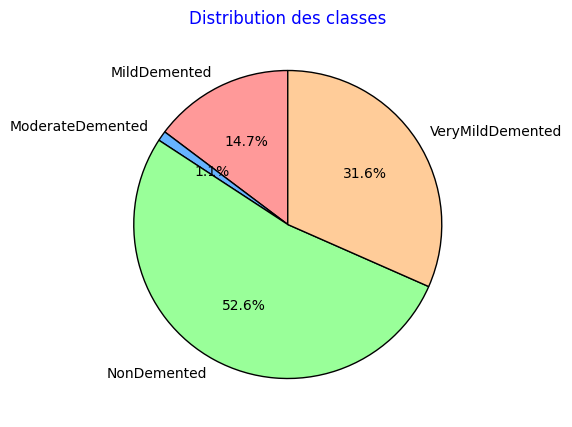

In [8]:
class_counts = {}
for cls in classes:
    class_path = os.path.join(path, cls)
    class_counts[cls] = len(os.listdir(class_path))

plt.figure(figsize=(5, 5)) 
plt.pie(
    class_counts.values(), 
    labels=class_counts.keys(), 
    autopct='%1.1f%%',  
    startangle=90, 
    colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'],  
    wedgeprops={'edgecolor': 'black'},
     
)
plt.title('Distribution des classes',color='blue')
plt.show()

>  le déséquilibre des classes n'est pas si critique qu'il nécessite une intervention via la data augmentation.

### **Affichage d'échantillons d'images :**

In [9]:
#Analyse des dimensions des images :
shapes = {}
for cls in classes:
    sample_path = os.path.join(path, cls, os.listdir(os.path.join(path, cls))[0])
    img = Image.open(sample_path)
    shapes[cls] = img.size
    print(f"{cls}: {shapes[cls]}")

MildDemented: (176, 208)
ModerateDemented: (176, 208)
NonDemented: (176, 208)
VeryMildDemented: (176, 208)


> Toutes les classes ont les mêmes dimensions d’images (176, 208)

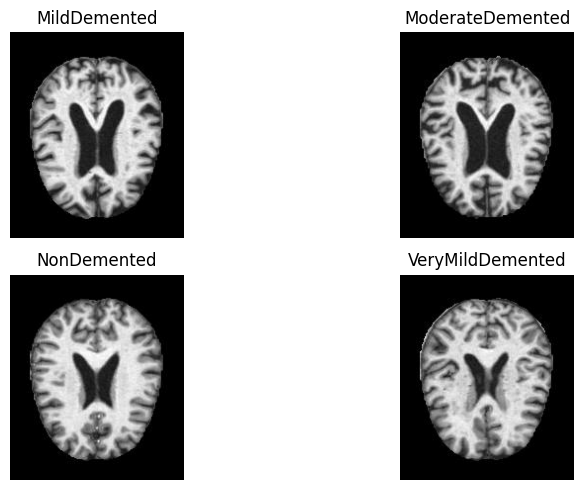

In [10]:
plt.figure(figsize=(10, 5))
for i, cls in enumerate(classes):
    sample_path = os.path.join(path, cls, os.listdir(os.path.join(path, cls))[0])
    img = Image.open(sample_path)
    plt.subplot(2, 2, i+1)
    plt.imshow(img,cmap='gray')
    plt.title(cls)
    plt.axis('off')
plt.tight_layout()
plt.show()

>**Cerveau non dement :** L'image IRM montre une structure cérébrale normale. Les régions du cerveau apparaissent intactes et bien définies.

>**Cerveau dement :** L'image IRM montre une atrophie cérébrale significative avec un rétrécissement marqué des régions cérébrales et un élargissement notable des ventricules(zones sombres).

### **Transformation et comparaison**

In [11]:
def select_random_image(dataset_path):
    all_images = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                all_images.append(os.path.join(root, file))
    return random.choice(all_images)

def rotate_image(image, degrees=45):
    return image.rotate(degrees, expand=True)

def add_random_noise(image, intensity):
    img_array = np.array(image)
    noise = np.random.normal(0, intensity*255, img_array.shape)
    noisy_array = img_array + noise
    return Image.fromarray(np.clip(noisy_array, 0, 255).astype(np.uint8))

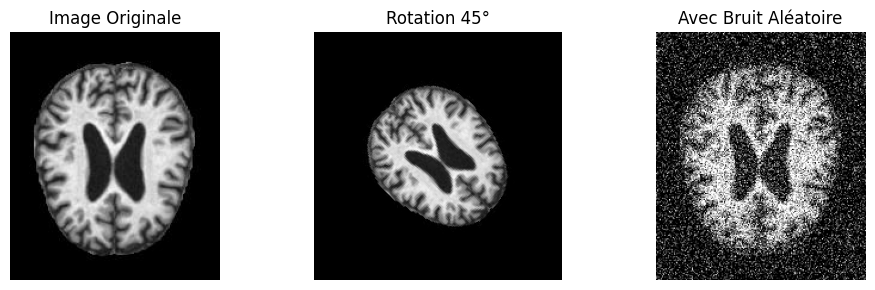

In [12]:
random_image_path = select_random_image(path)
original_image = Image.open(random_image_path)
rotated_image = rotate_image(original_image)
noisy_image = add_random_noise(original_image,0.3)

plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Image Originale')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(rotated_image, cmap='gray')
plt.title('Rotation 45°')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(noisy_image, cmap='gray')
plt.title('Avec Bruit Aléatoire')
plt.axis('off')
plt.tight_layout()
plt.show()

>   Les IRM cérébrales sont des données médicales sensibles. Toute transformation risque d'altérer des caractéristiques essentielles au diagnostic de la démence. La "data augmentation" pourrait introduire des artefacts ou masquer des signaux subtils, affectant ainsi l'apprentissage du modèle.

### **Préparation des données**

In [13]:
# Load and preprocess images
def load_images(path, classes, img_size=(128, 128)):
    images = []
    labels = []
    
    for class_idx, class_name in enumerate(classes):
        class_path = os.path.join(path, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                # Open image and convert to grayscale if needed
                img = Image.open(img_path).convert('L')
                # Resize image
                img = img.resize(img_size)
                # Convert to numpy array
                img_array = np.array(img)
                # Normalize to 0-1 range (but not standard normalization)
                img_array = img_array / 255.0
                # Add channel dimension
                img_array = np.expand_dims(img_array, axis=-1)
                
                images.append(img_array)
                labels.append(class_idx)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
    
    return np.array(images), np.array(labels)

In [14]:
# Load all images
X, y = load_images(path, classes)

# Convert labels to integer encoding (0, 1, 2, 3)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # y_encoded sera [0, 1, 2, 3] pour 4 classes

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y)  # On utilise `stratify=y` pour conserver les proportions

print(y_encoded)

[0 0 0 ... 3 3 3]


### **Création des modèles**

**CNN**

In [15]:
def create_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',  # <-- Adapté aux labels entiers
                  metrics=['accuracy'])
    return model

**CNN with attention**

In [28]:
def channel_attention(input_feature, ratio=8):
    """Channel Attention Module (like Squeeze-and-Excitation)"""
    channel = input_feature.shape[-1]
    
    gap = GlobalAveragePooling2D()(input_feature)
    dense1 = Dense(channel // ratio, activation='relu')(gap)
    dense2 = Dense(channel, activation='sigmoid')(dense1)
    attention = Reshape((1, 1, channel))(dense2)
    
    return Multiply()([input_feature, attention])

In [29]:
def spatial_attention(input_feature):
    """Spatial Attention Module (Keras-compatible)"""
    # Average and Max pooling across channels using Keras layers
    avg_pool = Lambda(lambda x: tf.reduce_mean(x, axis=3, keepdims=True))(input_feature)
    max_pool = Lambda(lambda x: tf.reduce_max(x, axis=3, keepdims=True))(input_feature)
    
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    attention = Conv2D(1, (7, 7), padding='same', activation='sigmoid')(concat)
    
    return Multiply()([input_feature, attention])

In [30]:
def create_cnn_with_dual_attention(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # Base CNN
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    
    # Apply Channel Attention
    x = channel_attention(x)
    
    # Apply Spatial Attention
    x = spatial_attention(x)
    
    # Classifier Head
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs, name='CNN_Dual_Attention')
    model.compile(optimizer='adam', 
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    return model

In [17]:
def spatial_attention(input_feature):
    # Average and Max pooling across channels
    avg_pool = tf.reduce_mean(input_feature, axis=3, keepdims=True)  # Shape: (H, W, 1)
    max_pool = tf.reduce_max(input_feature, axis=3, keepdims=True)   # Shape: (H, W, 1)
    
    # Concatenate and apply conv
    concat = Concatenate(axis=3)([avg_pool, max_pool])  # Shape: (H, W, 2)
    attention = Conv2D(1, (7, 7), padding='same', activation='sigmoid')(concat)  # Shape: (H, W, 1)
    
    return Multiply()([input_feature, attention])

In [18]:
def create_cnn_with_dual_attention(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # Base CNN
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    
    # Apply Channel Attention
    x = channel_attention(x)  # Refines "what" to focus on (channels)
    
    # Apply Spatial Attention
    x = spatial_attention(x)  # Refines "where" to focus (spatial regions)
    
    # Classifier Head
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs, name='CNN_Dual_Attention')
    model.compile(optimizer='adam', 
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    return model

**VGG pré-entraîné**

![VGG16](images/VGG16.png)

In [19]:
def create_vgg_model(input_shape, num_classes):
    # Convert grayscale to RGB by repeating the channel
    input_tensor = Input(shape=input_shape)
    x = Concatenate()([input_tensor, input_tensor, input_tensor])  # Convert to 3 channels
    
    # Load VGG16
    base_model = VGG16(weights='imagenet', 
                      include_top=False, 
                      input_tensor=x)
    
    # Freeze base model
    base_model.trainable = False
    
    # Add custom head
    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=input_tensor, outputs=predictions)
    model.compile(optimizer=Adam(0.001),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    return model

**GoogleNet (InceptionV3) pré-entraîné**

![InceptionV3](images/inception_v3.png)

In [20]:
def create_inception_model(input_shape, num_classes):
    # Input layer
    input_tensor = Input(shape=input_shape)
    
    # Convert grayscale to RGB using one of these methods:
    
    # Méthode 1: Répétition des canaux avec Lambda
    x = Lambda(lambda x: tf.repeat(x, 3, axis=-1))(input_tensor)
    
    # Méthode alternative 2: Convolution 1x1
    # x = Conv2D(3, (1, 1), padding='same')(input_tensor)
    
    # Load InceptionV3 with pre-trained weights
    base_model = InceptionV3(weights='imagenet',
                           include_top=False,
                           input_tensor=x)
    
    # Freeze base model
    base_model.trainable = False
    
    # Add custom head
    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=input_tensor, outputs=predictions)
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    
    return model

### **Entraînement des modèles**

In [21]:
def train_and_evaluate(model, X_train, y_train, epochs=10, batch_size=32):
    # Historique des métriques
    history = {
        'train_acc': [],
        'val_acc': [],
        'train_loss': [],
        'val_loss': [],
        'metrics': {
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': [],
            'auc': []
        }
    }
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        
        # Division train/val (stratifiée)
        X_tr, X_val, y_tr, y_val = train_test_split(
            X_train, y_train, 
            test_size=0.2, 
            random_state=epoch, 
            stratify=y_train
        )
        
        # Entraînement
        training = model.fit(
            X_tr, y_tr,
            validation_data=(X_val, y_val),
            epochs=1,
            batch_size=batch_size,
            verbose=1
        )
        
        # Sauvegarde des métriques de base
        history['train_acc'].append(training.history['accuracy'][0])
        history['val_acc'].append(training.history['val_accuracy'][0])
        history['train_loss'].append(training.history['loss'][0])
        history['val_loss'].append(training.history['val_loss'][0])
        
        # Prédictions et calcul des métriques avancées
        y_val_pred = model.predict(X_val)
        y_val_pred_labels = np.argmax(y_val_pred, axis=1)  # Conversion des probabilités en labels
        
        # Calcul des métriques (version compatible labels entiers)
        history['metrics']['accuracy'].append(accuracy_score(y_val, y_val_pred_labels))
        history['metrics']['precision'].append(
            precision_score(y_val, y_val_pred_labels, average='weighted'))
        history['metrics']['recall'].append(
            recall_score(y_val, y_val_pred_labels, average='weighted'))
        history['metrics']['f1'].append(
            f1_score(y_val, y_val_pred_labels, average='weighted'))
        
        history['metrics']['auc'].append(
            roc_auc_score(y_val, y_val_pred, multi_class='ovr'))

    # Visualisation
    plt.figure(figsize=(15, 5))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), history['train_acc'], label='Train Accuracy')
    plt.plot(range(1, epochs+1), history['val_acc'], label='Validation Accuracy')
    plt.title(f'Accuracy - {model.name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), history['train_loss'], label='Train Loss')
    plt.plot(range(1, epochs+1), history['val_loss'], label='Validation Loss')
    plt.title(f'Loss - {model.name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return history['metrics']

**CNN**

Training CNN model...

Epoch 1/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


122/122 ━━━━━━━━━━━━━━━━━━━━ 13s 96ms/step - accuracy: 0.4879 - loss: 1.0760 - val_accuracy: 0.5344 - val_loss: 0.9166
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step

Epoch 2/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 11s 93ms/step - accuracy: 0.5796 - loss: 0.9082 - val_accuracy: 0.6156 - val_loss: 0.8627
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step

Epoch 3/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step - accuracy: 0.6115 - loss: 0.8552 - val_accuracy: 0.6835 - val_loss: 0.7311
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step

Epoch 4/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step - accuracy: 0.6577 - loss: 0.7393 - val_accuracy: 0.7091 - val_loss: 0.6465
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step

Epoch 5/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step - accuracy: 0.6892 - loss: 0.6550 - val_accuracy: 0.7739 - val_loss: 0.5254
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step

Epoch 6/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step - accuracy: 0.7695 - loss: 0.5208 - val_accuracy: 0.8654 - val_loss: 0.3417
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step

Epoch 7/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step - accuracy: 0.8202 - loss: 0.4314 - val_accuracy: 0.8849 - val_loss: 0.2902
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step

Epoch 8/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step - accuracy: 0.8454 - loss: 0.3743 - val_accuracy: 0.9383 - val_loss: 0.2013
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step

Epoch 9/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 11s 92ms/step - accuracy: 0.8837 - loss: 0.2911 - val_accuracy: 0.9538 - val_loss: 0.1337
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step

Epoch 10/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step - accuracy: 0.9125 - loss: 0.2231 - val_accuracy: 0.9681 - val_loss: 0.1153
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


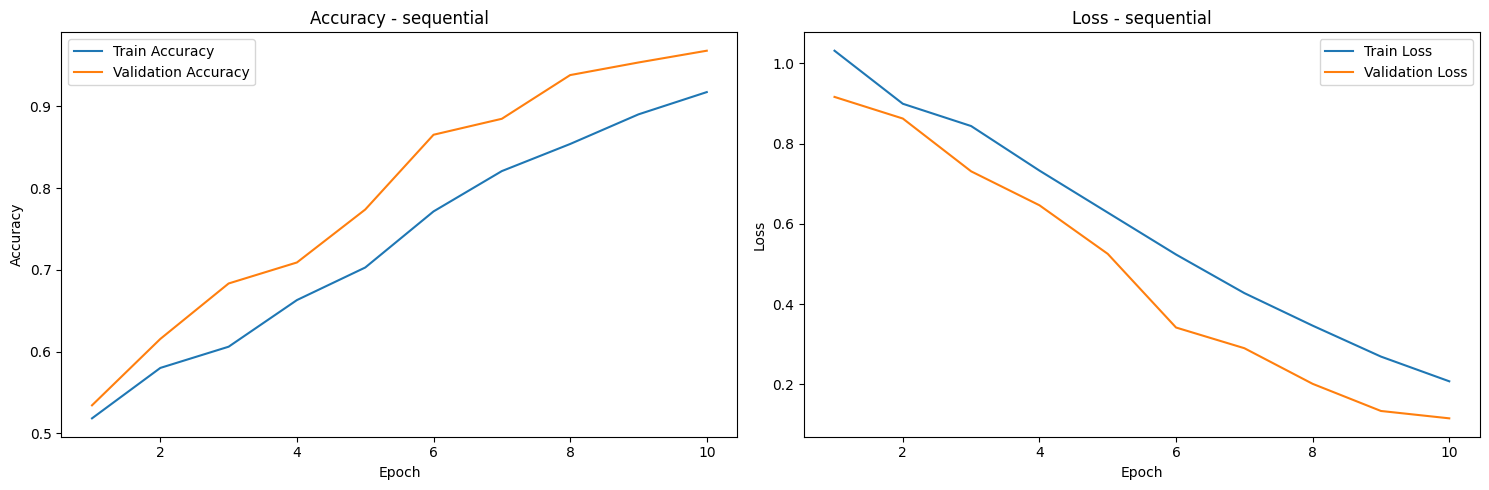

In [22]:
input_shape = X_train[0].shape
print("Training CNN model...")
cnn_model = create_cnn_model(input_shape, len(classes))
cnn_metrics = train_and_evaluate(cnn_model, X_train, y_train, epochs=10)

**CNN with both Spatial and Channel Attention**

Training CNN_att model...

Epoch 1/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 15s 115ms/step - accuracy: 0.5270 - loss: 1.0432 - val_accuracy: 0.5817 - val_loss: 0.8847
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step

Epoch 2/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 14s 114ms/step - accuracy: 0.6036 - loss: 0.8545 - val_accuracy: 0.6362 - val_loss: 0.7860
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step

Epoch 3/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 14s 115ms/step - accuracy: 0.6910 - loss: 0.7149 - val_accuracy: 0.6639 - val_loss: 0.7266
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step

Epoch 4/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 14s 115ms/step - accuracy: 0.7685 - loss: 0.5478 - val_accuracy: 0.7801 - val_loss: 0.4884
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step

Epoch 5/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 14s 115ms/step - accuracy: 0.8758 - loss: 0.3184 - val_accuracy: 0.8643 - val_loss: 0.3101
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step

Epoch 6/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 14s 114ms/step - accuracy: 0.9401 - loss: 0.1697 - val_accuracy: 0.9712 - val_loss: 0.0988
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step

Epoch 7/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 14s 115ms/step - accuracy: 0.9776 - loss: 0.0673 - val_accuracy: 0.9908 - val_loss: 0.0385
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step

Epoch 8/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 14s 114ms/step - accuracy: 0.9814 - loss: 0.0545 - val_accuracy: 0.9918 - val_loss: 0.0254
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step

Epoch 9/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 14s 114ms/step - accuracy: 0.9955 - loss: 0.0173 - val_accuracy: 0.9897 - val_loss: 0.0260
31/31 ━━━━━━━━━━━━━━

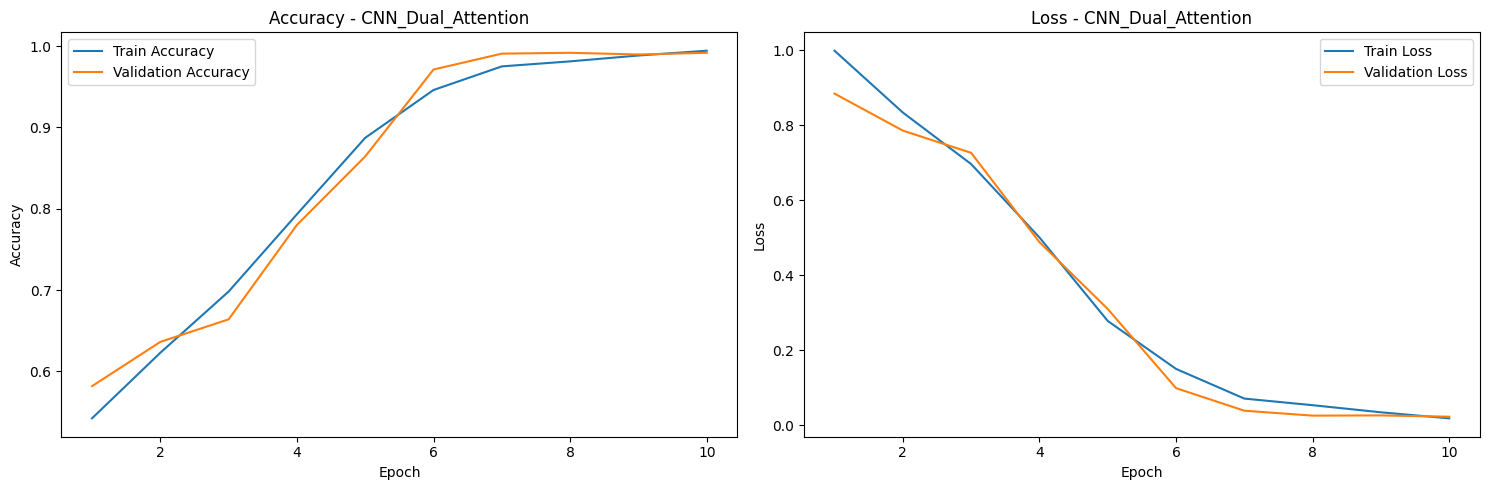

In [32]:
# Get input shape
input_shape = X_train[0].shape
# Create and train CNN model
print("Training CNN_att model...")
cnn_att_model = create_cnn_with_dual_attention(input_shape, len(classes))
cnn_att_metrics = train_and_evaluate(cnn_att_model, X_train, y_train, epochs=10)

**VGG16**


Training VGG16 model...

Epoch 1/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.4632 - loss: 1.3940 - val_accuracy: 0.5581 - val_loss: 0.9418
31/31 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step

Epoch 2/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 0.5672 - loss: 0.9558 - val_accuracy: 0.5468 - val_loss: 0.9389
31/31 ━━━━━━━━━━━━━━━━━━━━ 16s 499ms/step

Epoch 3/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 78s 637ms/step - accuracy: 0.5529 - loss: 0.9278 - val_accuracy: 0.6300 - val_loss: 0.8614
31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 493ms/step

Epoch 4/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 77s 634ms/step - accuracy: 0.5710 - loss: 0.9027 - val_accuracy: 0.5982 - val_loss: 0.8052
31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 491ms/step

Epoch 5/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 78s 641ms/step - accuracy: 0.5769 - loss: 0.8791 - val_accuracy: 0.6444 - val_loss: 0.7980
31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 492ms/step

Epoch 6/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 81s 665ms/step - accuracy: 0.5904 - loss: 0.8719 - val_accuracy: 0.6506 - val_loss: 0.7552
31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 480ms/step

Epoch 7/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 77s 632ms/step - accuracy: 0.6097 - loss: 0.8344 - val_accuracy: 0.6824 - val_loss: 0.7692
31/31 ━━━━━━━━━━━━━━━━━━━━ 16s 508ms/step

Epoch 8/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 76s 625ms/step - accuracy: 0.6072 - loss: 0.8179 - val_accuracy: 0.6804 - val_loss: 0.7769
31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 480ms/step

Epoch 9/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 76s 622ms/step - accuracy: 0.6035 - loss: 0.8423 - val_accuracy: 0.6948 - val_loss: 0.7453
31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 485ms/step

Epoch 10/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 76s 624ms/step - accuracy: 0.5864 - loss: 0.8371 - val_accuracy: 0.6506 - val_loss: 0.7681
31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 480ms/step


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


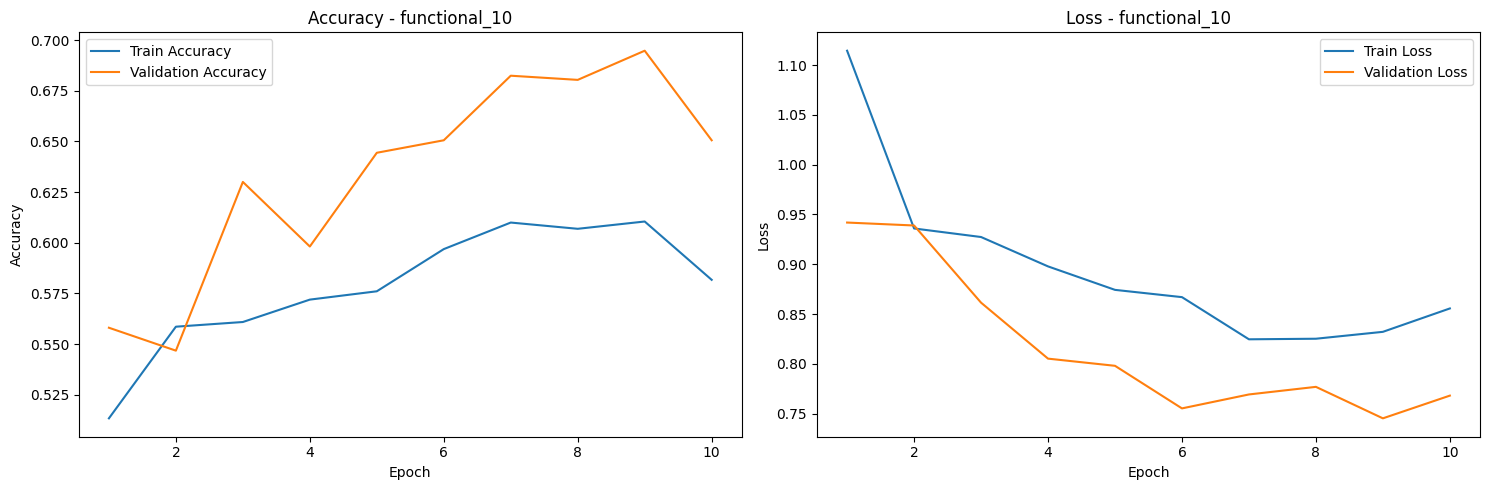

In [33]:
print("\nTraining VGG16 model...")
vgg_model = create_vgg_model(input_shape, len(classes))
vgg_metrics = train_and_evaluate(vgg_model, X_train, y_train)

**InceptionV3**


Training InceptionV3 model...

Epoch 1/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 24s 157ms/step - accuracy: 0.4772 - loss: 5.1535 - val_accuracy: 0.5365 - val_loss: 0.9086
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step

Epoch 2/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 18s 146ms/step - accuracy: 0.5198 - loss: 1.0062 - val_accuracy: 0.5262 - val_loss: 0.9106
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step

Epoch 3/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - accuracy: 0.5347 - loss: 1.0241 - val_accuracy: 0.5745 - val_loss: 0.8664
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step

Epoch 4/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 18s 144ms/step - accuracy: 0.5353 - loss: 0.9365 - val_accuracy: 0.5262 - val_loss: 0.8747
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step

Epoch 5/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - accuracy: 0.5362 - loss: 0.9568 - val_accuracy: 0.5940 - val_loss: 0.8686
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step

Epoch 6/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 18s 144ms/step - accuracy: 0.5354 - loss: 0.9530 - val_accuracy: 0.5262 - val_loss: 0.8377
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step

Epoch 7/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 18s 151ms/step - accuracy: 0.5563 - loss: 0.9247 - val_accuracy: 0.5262 - val_loss: 0.8531
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step

Epoch 8/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 18s 146ms/step - accuracy: 0.5414 - loss: 0.9356 - val_accuracy: 0.6043 - val_loss: 0.8176
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step

Epoch 9/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 17s 143ms/step - accuracy: 0.5596 - loss: 0.9072 - val_accuracy: 0.5550 - val_loss: 0.8995
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step

Epoch 10/10


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


122/122 ━━━━━━━━━━━━━━━━━━━━ 19s 152ms/step - accuracy: 0.5434 - loss: 0.9210 - val_accuracy: 0.6208 - val_loss: 0.7982
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


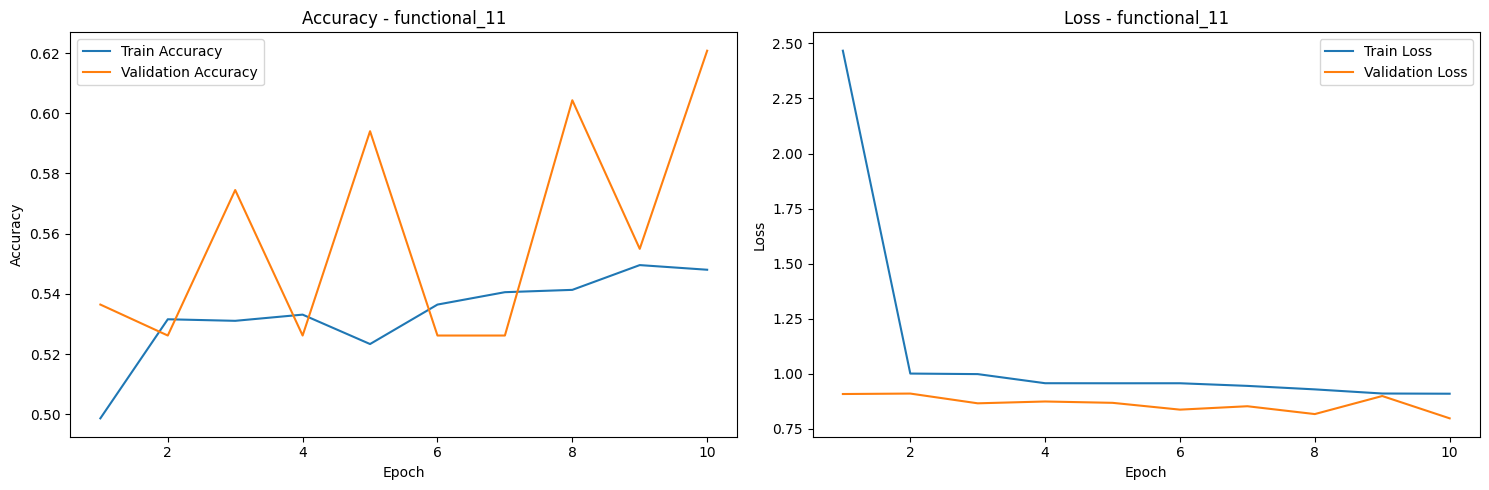

In [34]:
print("\nTraining InceptionV3 model...")
inception_model = create_inception_model(input_shape, len(classes))
inception_model._name = "InceptionV3"
inception_metrics = train_and_evaluate(inception_model, X_train, y_train, epochs=10)

**Comparaison lors de la phase de validation**

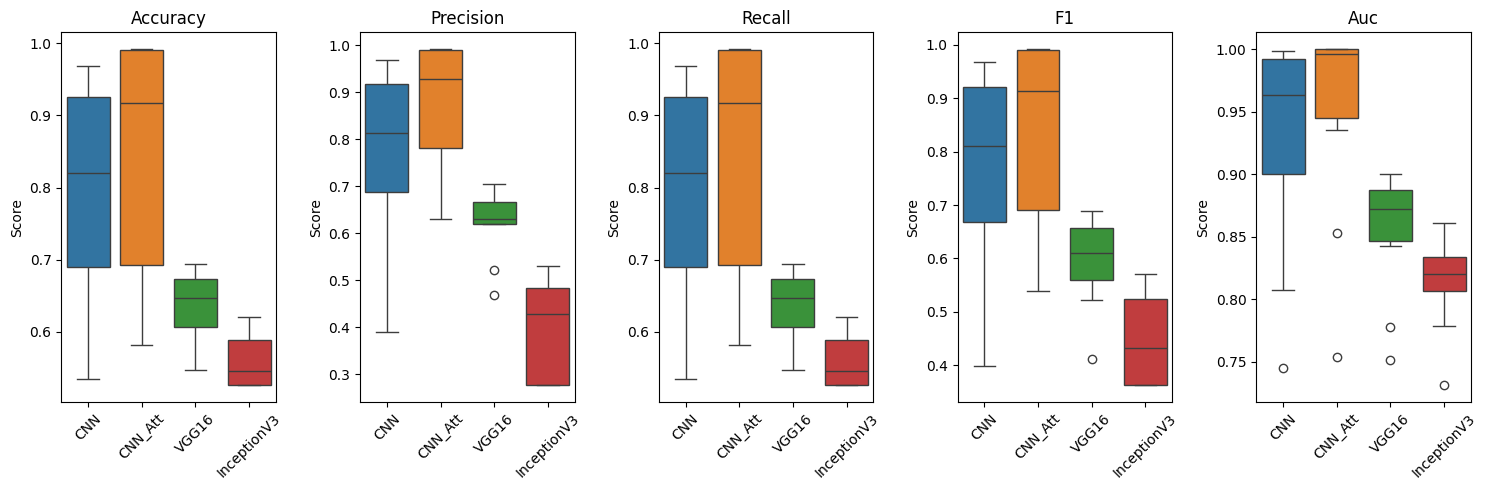

In [35]:
# Compare les performances des modèles lors de l'entraînement
metrics_names = ['accuracy', 'precision', 'recall', 'f1', 'auc']
plt.figure(figsize=(15, 5))

for i, metric in enumerate(metrics_names):
    plt.subplot(1, 5, i+1)
    data = {
        'CNN': cnn_metrics[metric],
        'CNN_Att': cnn_att_metrics[metric],
        'VGG16': vgg_metrics[metric],
        'InceptionV3': inception_metrics[metric]
    }
    sns.boxplot(data=pd.DataFrame(data))
    plt.title(metric.capitalize())
    plt.ylabel('Score')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

> Le modèle CNN_Att est clairement le plus performant et le plus stable. 

> L'ajout des mécanismes d’attention (spatiale et par canal) améliore significativement la capacité du réseau à capturer les zones discriminantes dans les images.

> Le CNN classique reste une bonne alternative. En revanche, VGG16 et InceptionV3 semblent mal adaptés à cette tâche spécifique (probablement liée aux IRM cérébrales).

### **Test et comparaison**

In [36]:
def evaluate_on_test(model, X_test, y_test):
    y_test_pred_proba = model.predict(X_test, verbose=0)     
    y_test_pred = np.argmax(y_test_pred_proba, axis=1)
    
    metrics = {
        'accuracy': accuracy_score(y_test, y_test_pred),
        'precision': precision_score(y_test, y_test_pred, average='weighted'),
        'recall': recall_score(y_test, y_test_pred, average='weighted'),
        'f1': f1_score(y_test, y_test_pred, average='weighted'),
        'auc': roc_auc_score(y_test, y_test_pred_proba, multi_class='ovr')
    }
    return metrics

In [37]:
# Evaluate all models on test set
test_results = []

models = {
    'CNN': cnn_model,
    'CNN_att': cnn_att_model,
    'VGG16': vgg_model,
    'InceptionV3': inception_model
}

for model_name, model in models.items():
    metrics = evaluate_on_test(model, X_test, y_test)
    metrics['model'] = model_name
    test_results.append(metrics)

# Create DataFrame with test results
test_results_df = pd.DataFrame(test_results)
test_results_df = test_results_df[['model', 'accuracy', 'precision', 'recall', 'f1', 'auc']]

print("\nTest Results:")
print(test_results_df)

c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Test Results:
         model  accuracy  precision    recall        f1       auc
0          CNN  0.930156   0.933437  0.930156  0.929827  0.993395
1      CNN_att  0.967132   0.968230  0.967132  0.967339  0.997418
2        VGG16  0.612161   0.595492  0.612161  0.555283  0.870329
3  InceptionV3  0.604766   0.515803  0.604766  0.556318  0.823031


c:\Users\skouz\OneDrive\Desktop\atelier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


> Les résultats de test confirment la supériorité du modèle CNN, qui surpasse nettement VGG16 et InceptionV3 sur tous les indicateurs de performance. Il démontre une excellente précision (94.6 %) et une AUC proche de 1, indiquant une très bonne capacité de généralisation.

### **Sauveguarde et importe du modele**

In [38]:
# Save models
save_model(cnn_model, 'cnn_model.h5')
save_model(cnn_att_model, 'cnn_att_model.h5')
save_model(vgg_model, 'vgg_model.h5')
save_model(inception_model, 'inception_model.h5')

In [47]:
# Charger le modèle
model_loaded = load_model("cnn_model.h5") 

In [56]:
def predict_with_random_image(model, dataset_path, class_names):
    """
    Version corrigée qui s'adapte automatiquement à la shape d'entrée du modèle
    """
    # Sélectionner une image aléatoire
    image_path = select_random_image(dataset_path)
    
    # Trouver la classe réelle
    true_class = os.path.basename(os.path.dirname(image_path))
    
    # Déterminer la taille d'entrée attendue par le modèle
    if len(model.input_shape) == 4:
        img_size = model.input_shape[1:3]  # (height, width)
        target_channels = model.input_shape[3]
    else:
        img_size = model.input_shape[1:]  # Cas particulier
        target_channels = 1
    
    # Charger et prétraiter l'image
    img = Image.open(image_path).convert('L').resize(img_size)
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=-1)  # (h, w, 1)
    
    # Adapter les canaux si nécessaire
    if target_channels == 3:
        img_array = np.repeat(img_array, 3, axis=-1)  # (h, w, 3)
    elif target_channels == 1:
        pass  # Déjà au bon format
    else:
        raise ValueError(f"Format de canal non supporté: {target_channels}")
    
    # Ajouter dimension batch (1, h, w, c)
    img_array = np.expand_dims(img_array, axis=0)
    
    try:
        # Faire la prédiction
        pred_proba = model.predict(img_array)
        pred_class_idx = np.argmax(pred_proba)
        pred_class = class_names[pred_class_idx]
        confidence = pred_proba[0][pred_class_idx]
        
        # Afficher les résultats
        plt.figure(figsize=(12, 5))
        
        # Image originale
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Image: {os.path.basename(image_path)}\nClasse réelle: {true_class}")
        plt.axis('off')
        
        # Probabilités
        plt.subplot(1, 2, 2)
        bars = plt.barh(class_names, pred_proba[0])
        bars[pred_class_idx].set_color('red')
        plt.title('Probabilités de prédiction')
        plt.xlabel('Confiance')
        plt.xlim([0, 1])
        
        plt.suptitle(f"Prédiction: {pred_class} (Confiance: {confidence:.2%})")
        plt.tight_layout()
        plt.show()
        
        print("\nDétails de prédiction:")
        for i, prob in enumerate(pred_proba[0]):
            print(f"{class_names[i]}: {prob:.2%}")
        
        return {
            'image_path': image_path,
            'true_class': true_class,
            'predicted_class': pred_class,
            'confidence': confidence,
            'probabilities': pred_proba[0].tolist()
        }
        
    except Exception as e:
        print(f"Erreur lors de la prédiction: {str(e)}")
        print(f"Shape de l'image fournie: {img_array.shape}")
        print(f"Shape attendue par le modèle: {model.input_shape}")
        return None

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


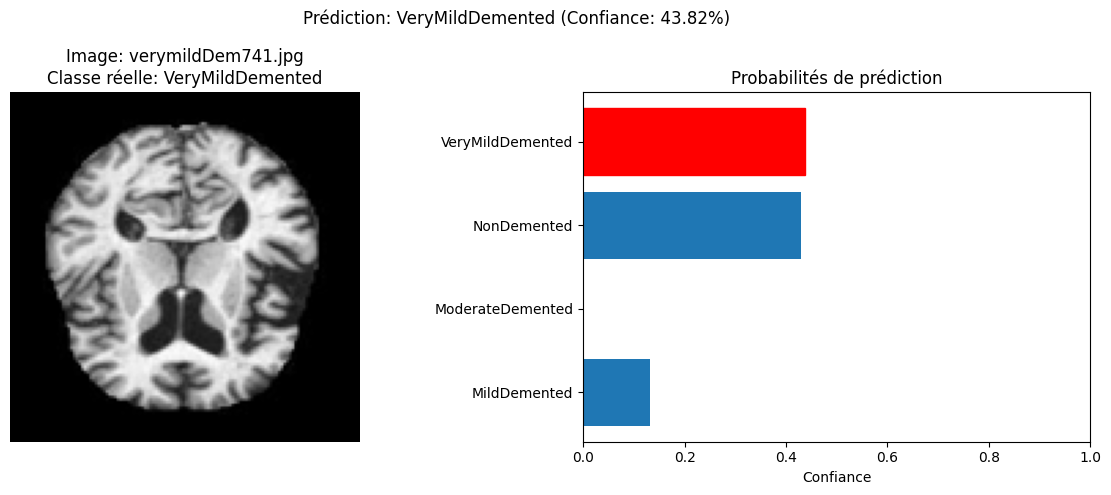


Détails de prédiction:
MildDemented: 13.12%
ModerateDemented: 0.03%
NonDemented: 43.03%
VeryMildDemented: 43.82%


In [57]:
# Faire une prédiction
result = predict_with_random_image(model, path, classes)